# DataSet e bibliotecas a serem usados no projeto

In [88]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import jax as jax
from typing import Callable
from sklearn.model_selection import train_test_split
import time
import timeit
import matplotlib.pyplot as plt

# user id | item id | rating | timestamp.
_df = pd.read_csv('ml-100k/u.data', delimiter='\t', header=None, names=['userId', 'movieId', 'rating', 'timeStamp'])
originalData = _df.pivot(index='userId', columns='movieId', values='rating')
print("total elements: ", _df.count().sum())
print(_df.head(), "\n", "new df size: ", originalData.shape)


total elements:  400000
   userId  movieId  rating  timeStamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596 
 new df size:  (943, 1682)


### Separação de dados de teste

De acordo com a documentação, os dados já estão ordenados de maneira aleatória, então podemos apenas pegar os primeiros 20% de entradas.

In [89]:
testData = _df[:int(0.2*len(_df))]
_df = _df[int(0.2*len(_df)):]

# Tratamento dos dados: transposição em matriz, preenchimento de dados faltantes, normalização

In [90]:
# Convertendo a lista de dados em uma tabela com usuários nas linhas, filmes nas colunas, contendo os ratings correspondentes.
trainData = _df.pivot(index='userId', columns='movieId', values='rating')
testData = testData.pivot(index='userId', columns='movieId', values='rating')

# Reindexando os dataframes separados para incluuir todos os userIds e movieIds do dataframe original
userIds = [_ for _ in range(1, 944)]
movieIds = [_ for _ in range(1, 1683)]

trainData = trainData.reindex(index=userIds, columns=movieIds)
testData = testData.reindex(index=userIds, columns=movieIds)

# trainData = trainData.apply(
#     lambda x: x.fillna(0) if x.isna().all() else x.fillna(x.mean(numeric_only=True)), axis=0)

# Preenchendo valores faltantes com zeros
trainData = trainData.fillna(0)
testData = testData.fillna(0)

trainData = jnp.array(trainData.values)
testData = jnp.array(testData.values)

print("Novo formato do DataFrame de treino: ", trainData.shape, "Elementos não-nulos: ", jnp.count_nonzero(trainData), '\n')
print("Novo formato do DataFrame de teste: ", testData.shape, "Elementos não-nulos: ", jnp.count_nonzero(testData), '\n')

Novo formato do DataFrame de treino:  (943, 1682) Elementos não-nulos:  80000 

Novo formato do DataFrame de teste:  (943, 1682) Elementos não-nulos:  20000 



In [91]:
def normalizeData(data:jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Normaliza dados de um array subtraindo médias normalizando em relação ao desvio padrão 
    de cada feature.

    Args:
        data (jnp.ndarray): Dados não normalizdos
        
    Returns:
        tuple[jnp.ndarray, jnp.ndarray]: Dados normalizados de treino e teste
    """

    # Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
    mean = jnp.mean(data, axis=0)
    std = jnp.std(data, axis=0) + 1e-8

    data = data - mean
    data = data / std
    
    return data

In [92]:
# Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
# Em alguns casos std era zero, e portanto um pequena constante é adicionada aos valroes para evitar divisão por zero
mean = jnp.mean(trainData, axis=0)
std = jnp.std(trainData, axis=0) + 1e-8

normalizedTrainData = trainData - mean
# normalizedTrainData = normalizedTrainData / std

# normalizedTestData = testData - mean
# normalizedTestData = normalizedTestData / std

# Normalizando os dados. 
# trainData = normalizeData(jnp.array(trainData.values))
# print(testData.shape)


# Definindo as funções para implementação do SVD e KNN

In [93]:
def reorder(eigenvalues:jnp.ndarray, eigenvectors:jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """ Reorders in descending order the eigenvalues and corresponding eigenvectors based on the eigenvectors values.

    Args:
        eigenvalues (jnp.ndarray): 1D array containing the eigenvalues.
        eigenvectors (jnp.ndarray): 2D array cotaining eigenvectors as columns.

    Returns:
        tuple[jnp.ndarray, jnp.ndarray]: Reordered eigenvalues and eigenvectors.
    """
    orderedIndices = jnp.argsort(eigenvalues, descending=True) 
    orderedEigenvalues = eigenvalues[orderedIndices] 
    orderedEigenvectors = eigenvectors[:, orderedIndices] 

    return orderedEigenvalues, orderedEigenvectors


def svd(data:jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """ From a data matrix, return its Singular Value Decomposition (SVD) 
    computed using the eigendecomposition of the data's covariance matrix.

    Args:
        data (jnp.ndarray): Rectangular matrix

    Returns:
        tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]: SVD of the data matrix, where data = U.S.V^T
    """

    # Computing the data matrix's right-singular vectors, as well as the singular values
    eigenvalues, rEigenvectors = jnp.linalg.eig(data.T @ data)
    eigenvalues, rEigenvectors = reorder(eigenvalues, rEigenvectors)
    Vt = jnp.real(rEigenvectors.T)    
    S = jnp.real(eigenvalues ** (1/2))

    # Computing the data matrix's left-singular vectors
    eigenvalues, lEigenvectors = jnp.linalg.eig(data @ data.T)
    eigenvalues, lEigenvectors = reorder(eigenvalues, lEigenvectors)
    U = jnp.real(lEigenvectors)

    
    return U, S, Vt

In [94]:
def knn(xTrain:jnp.ndarray, yTrain:jnp.ndarray, xTest:jnp.ndarray, k:int, metric:Callable[[jnp.ndarray, jnp.ndarray], float]) -> jnp.ndarray:
    """ Implementa a classificação de um conjunto de dados a partir do algoritmo de K-Nearest Neighbors (KNN).

    Args:
        xTrain (jnp.ndarray): Dados de treino
        yTrain (jnp.ndarray): Labels para os dados de treino
        xTest (jnp.ndarray): Dados de teste
        k (int): Número de vizinhos mais próximos usados para a classificação.
        metric (Callable): Função que calcula distância entre dois pontos.

    Returns:
        jnp.ndarray: Array contendo as predições realizadas para o conjunto de dados de teste xTest.
    """
    
    # Implementação JAX-friendly do cálculo da matriz de distâncias para um conjunto de pontos de teste.
    # O cálculo da matriz é feito vetorizando duas vezes a função de métrica, para calcular dois a dois
    # as distâncias entre pontos de treino e de teste.
    distances = jax.vmap(lambda train_point: jax.vmap(metric, in_axes=(None, 0))(train_point, xTest))(xTrain)

    # Ordenando as distâncias entre pontos, e pegando os targets/labels dos k pontos mais próximos para cada ponto de treino
    sorted_indices = jnp.argsort(distances, axis=0)
    nearestNeighborsIndices = sorted_indices[:k, :]
    nearestNeighbors = yTrain[nearestNeighborsIndices].astype(int)

    # Contagem dos números de cada target presente na lista de vizinhos próximos e definição do target estimado para o ponto
    # de teste baseado numa voto de maioria.
    totalLabels = 3
    targetCounts = jax.vmap(lambda neighbors: jnp.bincount(neighbors, minlength=totalLabels, length=3))(nearestNeighbors.T) 
    most_common_classes = jnp.argmax(targetCounts, axis=1)
    
    return most_common_classes

# Decomposição da matriz de dados

In [107]:
# Realizando a decomposição em valores singulares. U será composto vetores coluna ortogonais.  
# A pricípio, o ordenamento não é necessário pois svd() já retorna os valores singulares ordenados.  
# U, S, Vt = svd(trainData) 
U, S, Vt = jax.scipy.linalg.svd(normalizedTrainData) 

# Criando matriz de valores principais a partir de vetor 1D.
# Zero padding com colunas à direita necessário devido à dimensionalidade das matrizes U e Vt.
zeroColumns = Vt.shape[0] - U.shape[0]
zeroRows = U.shape[1]
_zeros = jnp.zeros((zeroRows, zeroColumns))

Sdiag = jnp.hstack([jnp.diag(S), _zeros])

print("Dimensões dos arrays obtidos: ", U.shape, Sdiag.shape, Vt.shape)

Dimensões dos arrays obtidos:  (943, 943) (943, 1682) (1682, 1682)


In [104]:
diff = []

arraySize = trainData.size

for nbComponents in range(1, 940, 10):
    
    UTrunk = U[:, :nbComponents]
    VtTrunk = Vt[:nbComponents, :]
    SdiagTrunk = Sdiag[:nbComponents, :nbComponents]

    approximateData = UTrunk @ SdiagTrunk @ VtTrunk

    approximateData = approximateData + mean
    approximateData
    
    diff.append(jnp.sum(jnp.abs(approximateData - trainData))/arraySize)

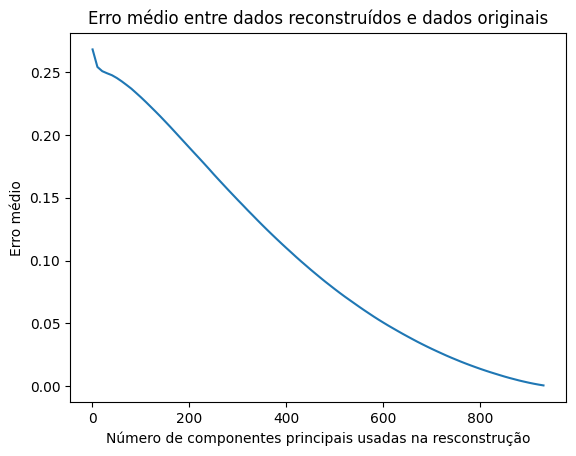

In [106]:
plt.plot(range(1, 940, 10), diff)

plt.title('Erro médio entre dados reconstruídos e dados originais')
plt.xlabel('Número de componentes principais usadas na resconstrução')
plt.ylabel('Erro médio')

plt.show()

O gráfico acima mostra o erro médio, tomado elemento por elemento da matriz de dados. Os dados reconstruídos são obtidos pela multiplicação das matrizes SVD com um certo número de componentes. 

Alguns aspectos desse gráfico fazem sentido: o erro médio deveria se reduzir à medida que mais componentes principais vão sendo consideradas na decomposição dos dados, até que, quando usadas todas as componentes possíveis, o erro converge para zero.

No entanto, o erro quando consideradas pouquíssimas componentes (<10) parece ainda muito baixo. Não sei dizer se esse seria o comportamento esperado do algoritmo, ou se algo na minha implementação não está correto. 

# Previsão dos dados guardados no começo para teste

In [117]:
# Quero gerar um array com apenas os valores correspondentes ao conjunto de teste, mas com os valores do array aproximado
testDataMask = jnp.where(testData != 0, 1, 0)

testError = []

for nbComponents in range(1, 940, 10):
    
    UTrunk = U[:, :nbComponents]
    VtTrunk = Vt[:nbComponents, :]
    SdiagTrunk = Sdiag[:nbComponents, :nbComponents]

    approximateData = UTrunk @ SdiagTrunk @ VtTrunk

    approximateData = approximateData + mean
    approximateData
    
    filteredApproximateData = approximateData * testDataMask

    testError.append(jnp.sum(jnp.abs(filteredApproximateData - testData))/20000)

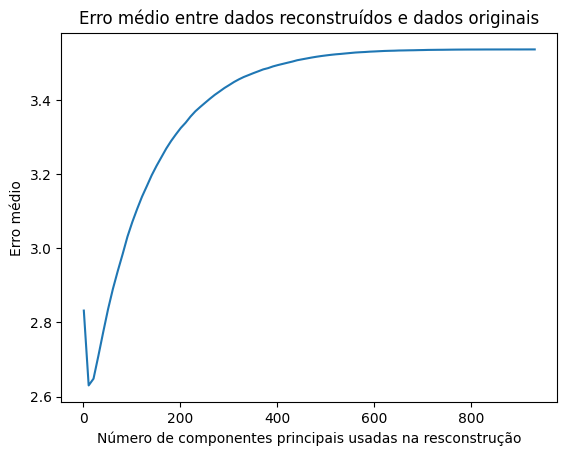

In [118]:
plt.plot(range(1, 940, 10), testError)

plt.title('Erro médio entre dados estimados e dados originais')
plt.xlabel('Número de componentes principais usadas na estimativa')
plt.ylabel('Erro médio')

plt.show()

A ideia seria que quanto mais componentes fossem utilizadas na estimativa do valor "escondido" dos dados de teste, melhor seria essa previsão. Não somente os erros estão muito maiores do que no gráfico anterior (reconstrução da matriz de dados inteira), como o comportamento mostrado é completamente o oposto do que seria esperado. Algo certamente não está dando certo, mas não estou conseguindo achar o erro, ou uma explicação para o porque disso estar acontecendo. 

# Análise dos valores e vetores principais

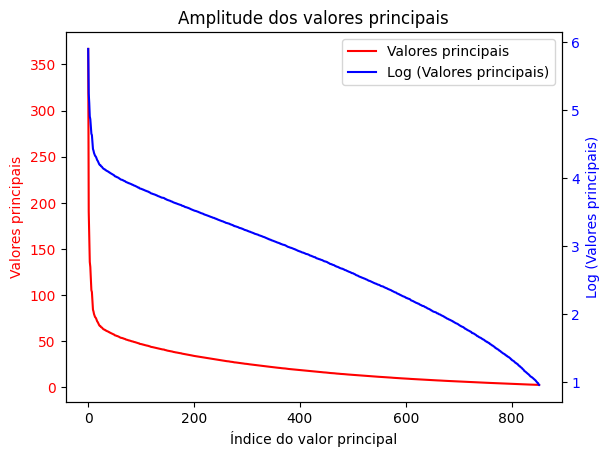

In [86]:
# Removidos os últimos valores principais do plot apenas para melhor 
# visualização do gráfico em escala log (os últimos valores são muito próximos de zero)
Splot = S[:-10]

x = range(0, len(Splot))

fig, ax1 = plt.subplots()

line1, = ax1.plot(x, Splot, 'r-', label='Valores principais')
ax1.set_xlabel('Índice do valor principal') 
ax1.set_ylabel('Valores principais', color='r')  
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
line2, = ax2.plot(x, jnp.log(Splot), 'b-', label='Log (Valores principais)')
ax2.set_ylabel('Log (Valores principais)', color='b') 
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Amplitude dos valores principais')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.show()

O ponto onde a curva em escala log transiciona de inclinação está entre os 15 - 20 primeiros valores principais. Suponho que esses sejam os valores principais referentes aos gêneros de filme incluídos no dataset (18 gêneros definidos + uma categoria "desconhecidos"), porém seria necessário estudar mais a fundo os vetores principais associados a cada um desses valores.

Para descobrir isso, seria necessário pegar cada um dos vetores principais nas linhas de Vt. Caso a hipótese acima seja verdadeira, o vetor principal associado ao gênero Ação, por exemplo, terá componentes de maior amplitude nos índices associados aos filmes de ação da matriz de dados.

# Testando a implementação da decomposição em valores principais a partir dos autovalores e autovetores da matriz de covariância dos dados.

Aqui geramos uma matriz aleatória, calculamos seus valores e vetores principais, e comparamos com a implementação nativa do JAX para fins de checagem de sanidade. 

Vemos que a matrix ortogonal de vetores principais não é a mesma obtida pela implementação do JAX, porém isso acontece somente devido a uma inversão do sinal de alguns dos vetores. Nas matrizes U e Ut, isso se traduz respectivamente em uma inversão de sinal de colunas ou linhas especificas, o que não altera as propriedades matemáticas da nossa decomposição. Portanto, a menos de desvios numéricos, temos uma implementação equivalente feita a partir dos autovetores e autovalores da matriz de dados. 

In [43]:
# Gerando os dados aleatórios para teste
key = jax.random.PRNGKey(0)
random_array = jax.random.uniform(key, (5, 4))
data = random_array
covarianceMatrix = (1/len(data)) * data.T @ data

# Calculando a SVD usando dois métodos diferentes: implementação nativa e usando autovalores e autovetores
U1, S1, Vt1 = jax.scipy.linalg.svd(covarianceMatrix) 
U2, S2, Vt2 = svd(covarianceMatrix) 

In [44]:
# Os dois arrays devem ser iguais, a menos de um sinal em cada coluna
print("Comparando U: ")
print(U1)
print(U2)

# Os dois arrays devem ser iguais, a menos de um sinal em cada linha
print("\n\nComparando Ut: ")
print(Vt1)
print(Vt2)

# Os valores principais devem ser exatamente iguais
print("\n\nComparando valores principais: ")
print(S1)
print(S2)

Comparando U: 
[[-0.5625489   0.7061049  -0.26226145 -0.34084198]
 [-0.45437548 -0.49096245  0.43556333 -0.60231495]
 [-0.4274326  -0.50450015 -0.71912175  0.21364647]
 [-0.5425707   0.07649231  0.47367406  0.6894916 ]]
[[ 0.56254894 -0.70610535  0.26226294  0.34084186]
 [ 0.4543755   0.4909616  -0.43556163  0.6023146 ]
 [ 0.42743263  0.5045007   0.71912086 -0.21364544]
 [ 0.54257077 -0.07649165 -0.4736765  -0.6894922 ]]


Comparando Ut: 
[[-0.56254894 -0.4543754  -0.4274326  -0.5425706 ]
 [ 0.706105   -0.49096242 -0.50450003  0.07649231]
 [-0.26226142  0.43556345 -0.719122    0.47367418]
 [-0.340842   -0.60231483  0.21364635  0.6894918 ]]
[[ 0.56254894  0.4543755   0.42743257  0.5425707 ]
 [-0.7061053   0.49096262  0.5044998  -0.07649182]
 [ 0.26226133 -0.435565    0.7191219  -0.47367254]
 [ 0.3408419   0.60231435 -0.21364391 -0.689493  ]]


Comparando valores principais: 
[1.2094074  0.1760837  0.10692322 0.05494076]
[1.2094078  0.17608385 0.10692321 0.05494073]


Apesar dos valores parecerem bem compatíveis, apresentando divergências somente a partir da escala ~1e-6, notei que isso criar diferenças perceptíveis na reconstrução da matriz de dados a partir das matrizes SVD, em comparação à implementação própria do JAX. Não consegui identifcar se esse problema se deve à normalização errada dos dados, ou se é simplesmente uma consequência do modelo. 

Ao longo do notebook, decidi por deixar minha implementação a partir de autovetores de lado, já que estava obtendo resultados melhores com a implementação direta do jax.linalg. 